<a href="https://colab.research.google.com/github/Nozarchos/hackathon_cardiospike/blob/main/heuristicsbaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heuristic algorithm for detecting anomalies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings; warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score 

In [2]:
train = pd.read_csv('/content/drive/MyDrive/CardioSpike/data/train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60487 entries, 0 to 60486
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      60487 non-null  int64
 1   time    60487 non-null  int64
 2   x       60487 non-null  int64
 3   y       60487 non-null  int64
dtypes: int64(4)
memory usage: 1.8 MB


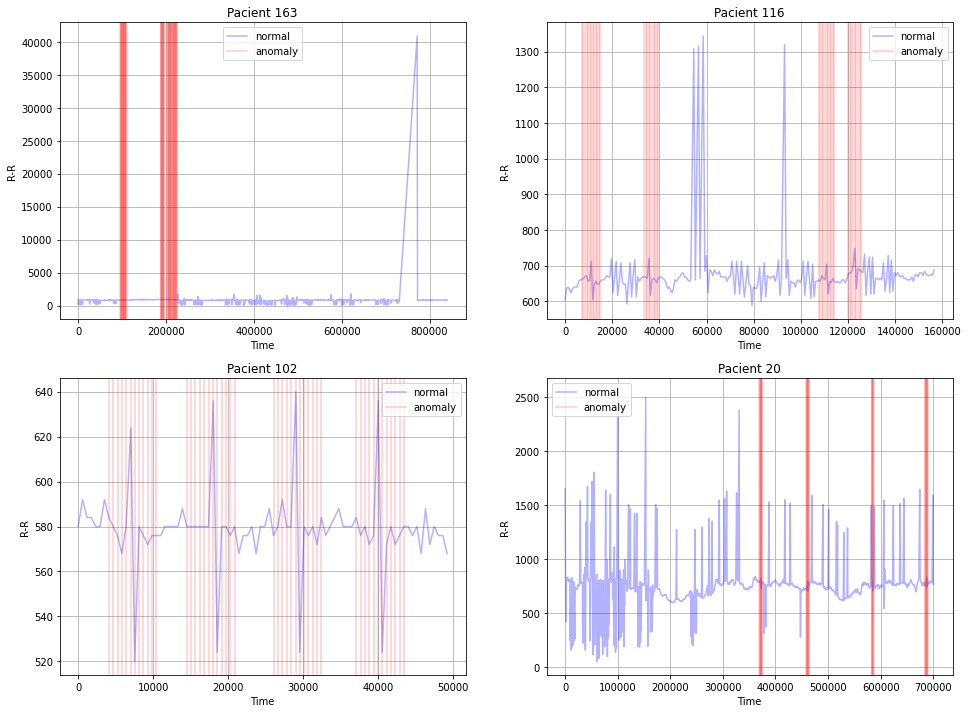

In [4]:
plt.figure(figsize=(16, 12))
i = 0
for id in train[train['y'] == 0].sample(4)['id'].unique():
    size = np.ceil(len(train[train['y'] == 1].sample(4)['id'].unique()) ** .5)
    plt.subplot(size, size, i + 1)
    i += 1
    id_data = train[train['id'] == id]
    plt.plot(id_data['time'], id_data['x'], 'blue', alpha=0.3);
    already = []
    for x in range(len(id_data)):
        if id_data['y'].iloc[x] == 1:
            plt.axvline(id_data['time'].iloc[x], color='red', alpha=0.2, label='anomaly')
    plt.xlabel("Time")
    plt.ylabel("R-R")
    plt.grid(True)
    plt.legend(['normal', 'anomaly'])
    plt.title('Pacient ' + f'{id}')
plt.savefig('bulk1_view.jpg', bbox_inches='tight')

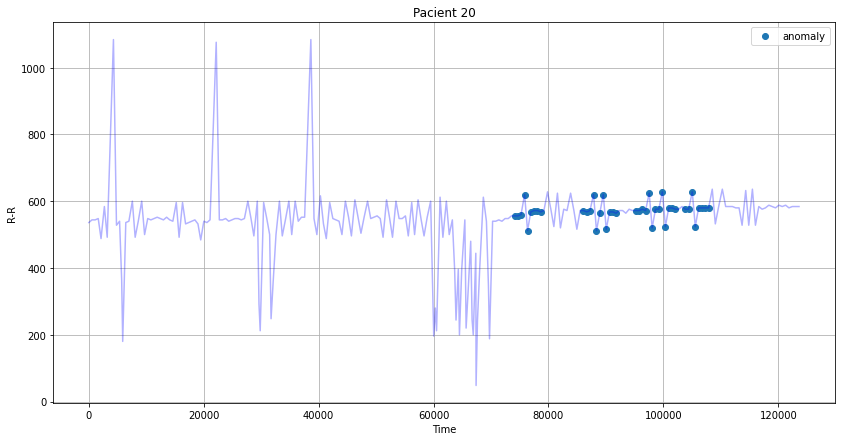

In [5]:
plt.figure(figsize=(14, 7))
id_data = train[train['id'] == 138]
plt.plot(id_data['time'][id_data['y'] == 1], id_data['x'][id_data['y'] == 1], 'o', label='anomaly')
plt.plot(id_data['time'], id_data['x'], 'blue', alpha=0.3);
plt.xlabel("Time")
plt.ylabel("R-R")
plt.grid(True)
plt.legend()
plt.title('Pacient ' + f'{id}')
plt.savefig('far_view.jpg', bbox_inches='tight')

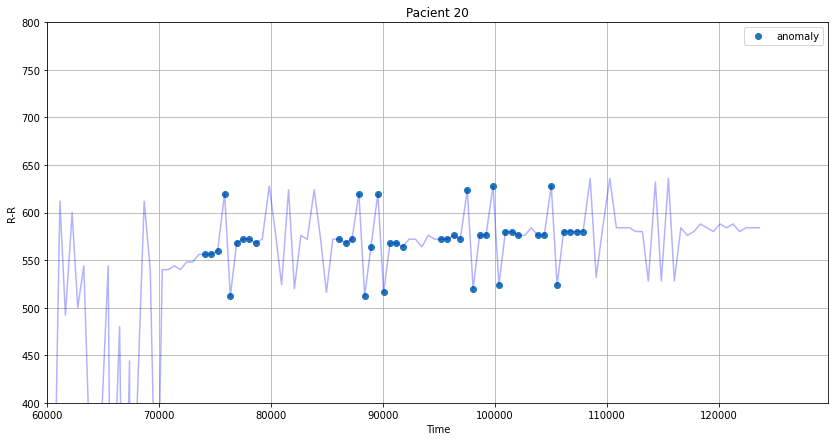

In [6]:
plt.figure(figsize=(14, 7))
id_data = train[train['id'] == 138]
plt.plot(id_data['time'][id_data['y'] == 1], id_data['x'][id_data['y'] == 1], 'o', label='anomaly')
plt.plot(id_data['time'], id_data['x'], 'blue', alpha=0.3)
plt.legend()
plt.xlim(60000)
plt.ylim(400, 800)
plt.xlabel("Time")
plt.ylabel("R-R")
plt.grid(True)
plt.legend()
plt.title('Pacient ' + f'{id}')
plt.savefig('near_view.jpg', bbox_inches='tight')

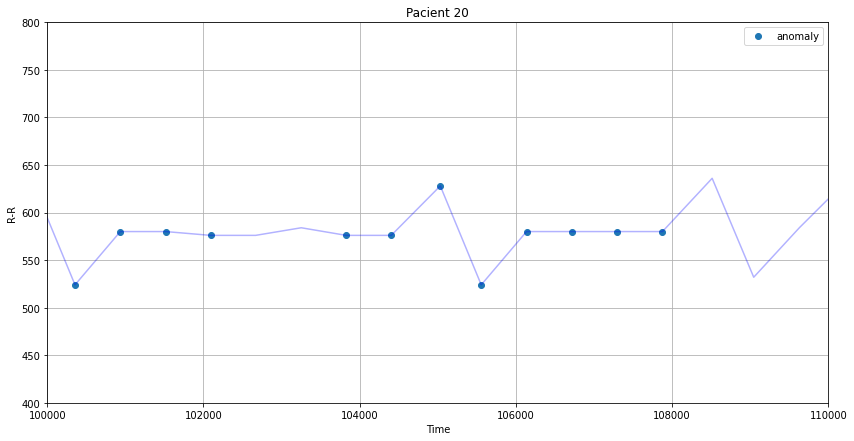

In [7]:
plt.figure(figsize=(14, 7))
id_data = train[train['id'] == 138]
plt.plot(id_data['time'][id_data['y'] == 1], id_data['x'][id_data['y'] == 1], 'o', label='anomaly')
plt.plot(id_data['time'], id_data['x'], 'blue', alpha=0.3)
plt.legend()
plt.xlim(100_000, 110_000)
plt.ylim(400, 800)
plt.xlabel("Time")
plt.ylabel("R-R")
plt.grid(True)
plt.legend()
plt.title('Pacient ' + f'{id}')
plt.savefig('near_near_view.jpg', bbox_inches='tight')

# No ML

In [8]:
def no_ml_predicter(df, min_rise=20, max_rise=70, first_plateau=25, second_plateau=25, height=25):
    if 'y' in df.columns:
        col_name = 'y_'
    else:
        col_name = 'y'
    df[col_name] = 0
    for x in range(len(df)-5):
        if df['x'].iloc[x] < 500:
            continue
        # there should be a plateau at the beginning
        next = df['x'].iloc[x+1]
        curr = df['x'].iloc[x]
        if abs(next - curr) <= first_plateau:  
            first_rise = df['x'].iloc[x+2] - next
            # growing after that
            if min_rise <= first_rise <= max_rise:
                # then a sharp descent
                if df['x'].iloc[x+3] < (next - (0.5 * first_rise)):
                    # plateau again
                    if abs(df['x'].iloc[x+4] - curr) <= second_plateau:
                        # difference between plateaus
                        if abs(df['x'].iloc[x+4] - df['x'].iloc[x+5]) <= height:
                            df.iloc[x:x+6, df.columns.get_loc(col_name)] = 1
    
    return df

In [9]:
test = pd.read_csv('/content/drive/MyDrive/CardioSpike/data/test.csv')

In [10]:
test = no_ml_predicter(test)

In [11]:
test[['id', 'time', 'y']].to_csv('naz_sub1.csv', index=False)

In [12]:
%%time
no_ml_predicter(train[train['id'] == 136])

CPU times: user 21.9 ms, sys: 645 µs, total: 22.5 ms
Wall time: 27.2 ms


,id,time,x,y,y_
28571,136,0,588,0,0
28572,136,496,496,0,0
28573,136,992,496,0,0
28574,136,1084,92,0,0
28575,136,1568,484,0,0
...,...,...,...,...,...
29189,136,331280,556,0,0
29190,136,331840,560,0,0
29191,136,332156,316,0,0
29192,136,332392,236,0,0


In [13]:
train = no_ml_predicter(train)
f1_score(train['y_'], train['y'])

0.6920626665799909

In [14]:
id_136 = train[train['id'] == 136]

In [15]:
fig = px.line(id_136, x='time', y='x', color='y')
fig.show()

In [16]:
fig = px.line(id_136, x='time', y='x', color='y_')
fig.show()

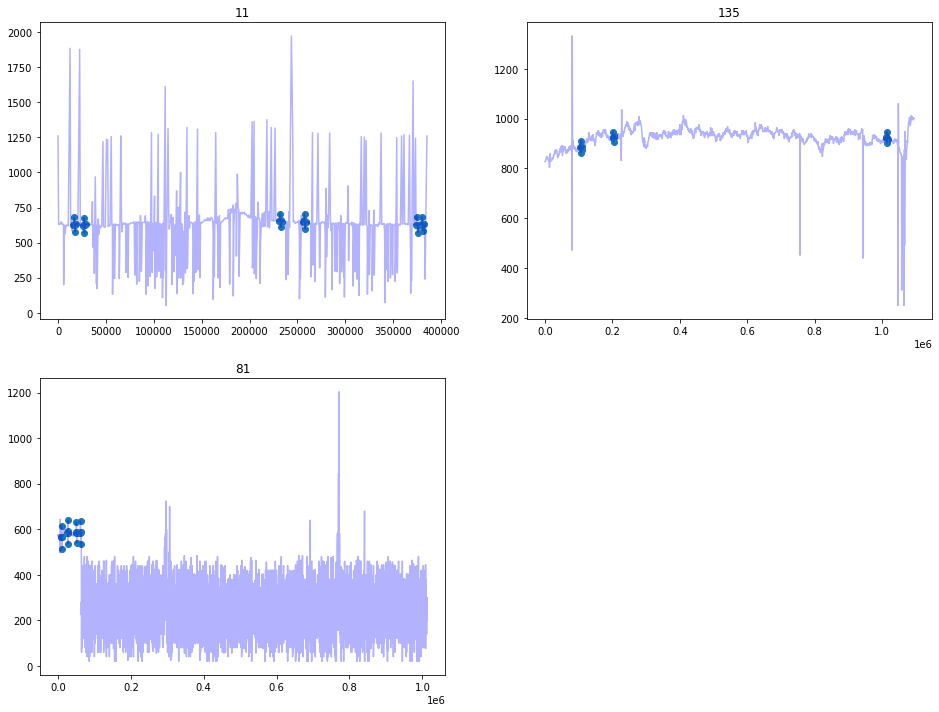

In [17]:
plt.figure(figsize=(16, 12))
i = 0
for id in test[test['y'] == 0].sample(4)['id'].unique():
    size = np.ceil(len(test[test['y'] == 1].sample(4)['id'].unique()) ** .5)
    plt.subplot(size, size, i + 1)
    i += 1
    id_data = test[test['id'] == id]
    plt.plot(id_data['time'][id_data['y'] == 1], id_data['x'][id_data['y'] == 1], 'o')
    plt.plot(id_data['time'], id_data['x'], 'blue', alpha=0.3);
    plt.title(f'{id}')
plt.show()